## 1. Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## 2. import data

In [4]:
booking_data = pd.read_csv('Bookings.csv')
booking_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data preprocessing

In [5]:
df=booking_data.copy()

In [6]:
# missing data values check
df.isnull().sum().sort_values(ascending= False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

In [7]:
# replacing null values of agent with 0 
df[['agent','company']]=df[['agent','company']].fillna(0.0)

In [8]:
# replacing country and children values with mean and mode imputation
df['country'].fillna(booking_data.country.mode().to_string(), inplace = True)


df['children'].fillna(round(booking_data.children.mean()), inplace = True)

In [9]:
a=df['babies'].unique()
print('unique values of babies are:',a)
b=df['children'].unique()
print('unique values of children are: ',b)
c=df['adults'].unique()
print('unique values of adults are: ',c)

unique values of babies are: [ 0  1  2 10  9]
unique values of children are:  [ 0.  1.  2. 10.  3.]
unique values of adults are:  [ 2  1  3  4 40 26 50 27 55  0 20  6  5 10]


In [10]:
# treating undefined values in meal column
df['meal'].replace(to_replace='Undefined',value='BB',inplace=True)

In [11]:
# treating undefined values in distribution_channel column
df['distribution_channel'].replace(to_replace='Undefined',value='TA/TO',inplace=True)

In [12]:
# treating undefined values in market_segment cdolumn 
df['market_segment'].replace(to_replace='Undefined',value='Online TA',inplace=True)

In [13]:
# checking for duplicate values
dupli = df.duplicated()
print('no of duplicated values in the data set: ',dupli.sum())

no of duplicated values in the data set:  31994


In [14]:
# deleting the duplicate values
df.drop_duplicates(inplace=True)
df.shape

(87396, 32)

In [15]:
df[(df.adults+df.babies+df.children)==0].shape

(166, 32)

In [16]:
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

In [17]:
df.shape

(87230, 32)

In [18]:
# converting data types
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')


In [19]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

## EDA

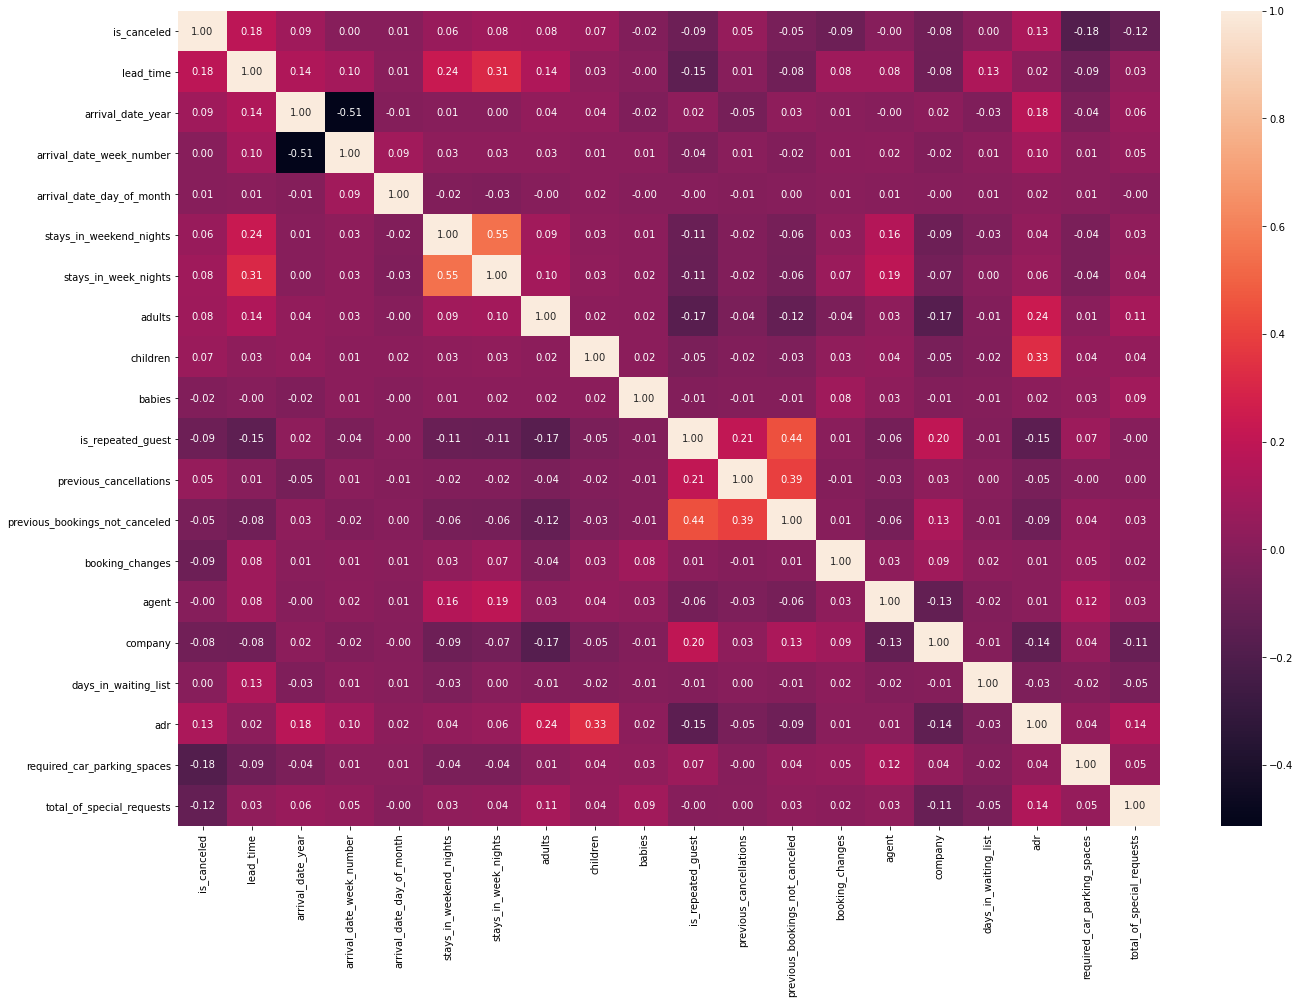

In [20]:
plt.figure(figsize=(22, 15))
sns.heatmap(df.corr(), annot=True, fmt='.2f');

In [21]:
# defining this function to get the counts of is_canceled columns
def count(series, limit=None):
    if limit!= None:
        series=series.value_counts()[:limit]
    else:
        series= series.value_counts()
    
    x=series.index
    y=series/series.sum()*100
    
    return x.values,y.values

In [22]:
# call function
x,y = count(df['is_canceled'])

In [23]:
x,y

(array([0, 1], dtype=int64), array([72.47621231, 27.52378769]))

In [24]:
# plottinh this result
def plot(x,y,x_label=None, y_label=None, title=None, figsize=(7,5),type='bar'):
    sns.set_style('darkgrid')
    fig, ax=plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    if x_label != None:
        ax.set_label(x_label)
    if y_label != None:
        ax.set_label(y_label)
    if title != None:
        ax.set_label(title)
    if type == 'bar':
        sns.barplot(x,y,ax=ax)
    elif type == 'line':
        sns.lineplot(x,y, ax=ax,sort = False)
        
    
    plt.show()
    

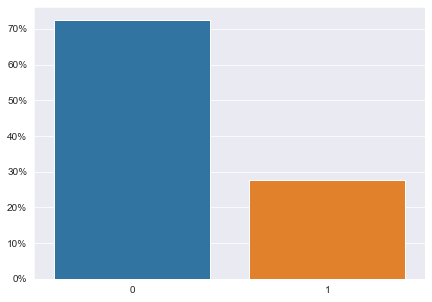

In [25]:
# x-axis = total booking %
#y-axis = Booking caancelled n0=0 yes =1
plot(x,y,x_label='Booking cancelled (no=0, yes=1)',y_label='booking (%)')
plt.show()

In [26]:
# further analysis we will select only the bookings that were not cancelleed
df_not_canceled = df[df['is_canceled']==0]

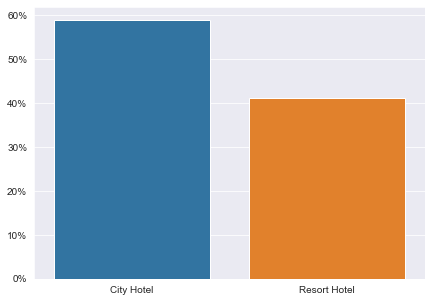

In [27]:
# booking % comparision wrt city hotel and resort hotel
x,y = count(df_not_canceled['hotel'])
plot(x,y,x_label='Hotels', y_label='Total booking(%)', title='Hotel comparision')

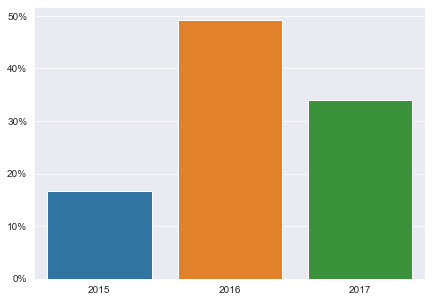

In [28]:
#3 percentage of booking for each year
x,y = count(df_not_canceled['arrival_date_year'])
plot(x,y, x_label='Year',y_label='total boking(%)',title='year comparision')

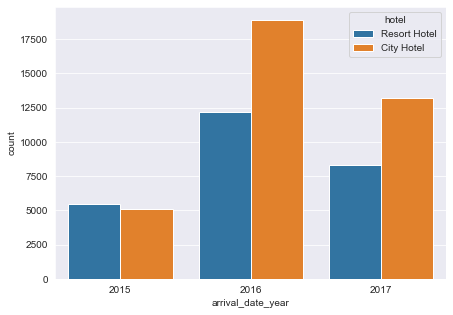

In [29]:
# the same graph by seperating hotel and plotting 
plt.subplots(figsize=(7,5))
sns.countplot(x='arrival_date_year',hue='hotel',data=df_not_canceled);

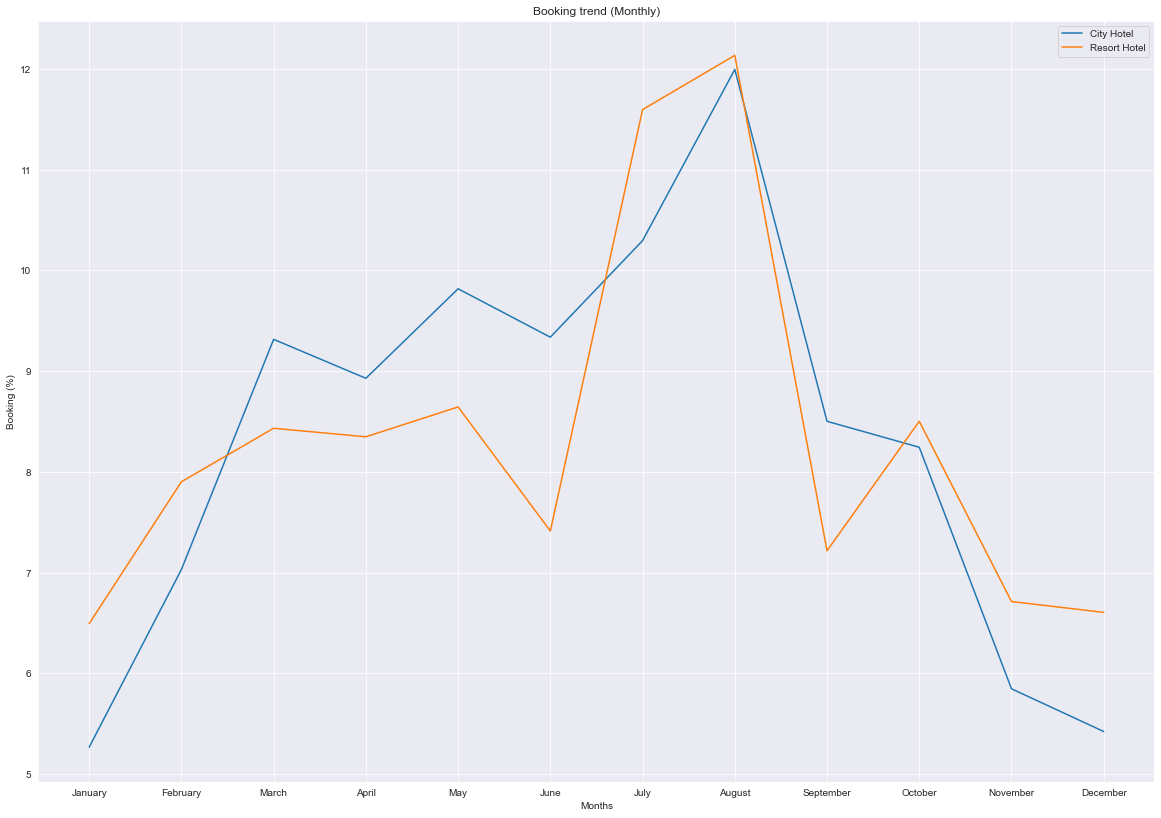

In [30]:
# busiest month for the hotel
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
             'November', 'December']

sorted_months=df_not_canceled.loc[df.hotel=='City Hotel','arrival_date_month'].value_counts().reindex(new_order)

x1 = sorted_months.index
y1= sorted_months/sorted_months.sum()*100




sorted_months=df_not_canceled.loc[df.hotel=='Resort Hotel','arrival_date_month'].value_counts().reindex(new_order)

x2= sorted_months.index
y2= sorted_months/sorted_months.sum()*100



fig, ax=plt.subplots(figsize=(20,14))

ax.set_xlabel('Months')
ax.set_ylabel('Booking (%)')
ax.set_title('Booking trend (Monthly)')

sns.lineplot(x1, y1.values, label='City Hotel', sort= False)
sns.lineplot(x1, y2.values, label='Resort Hotel', sort=False)
plt.show()

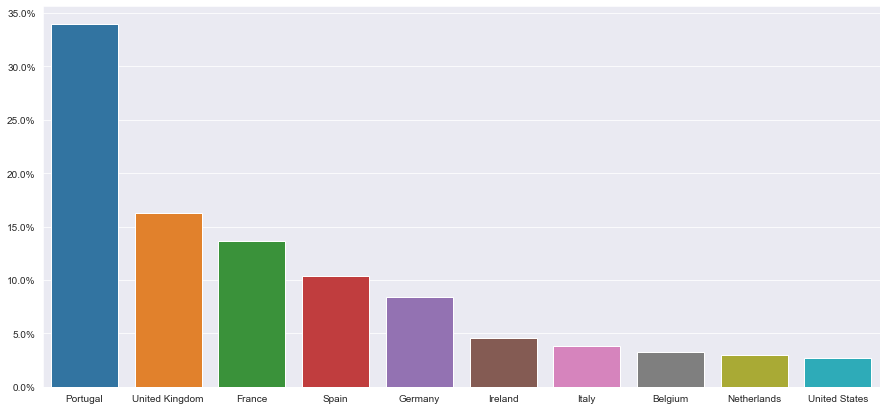

In [31]:
# from which country more guests have visited the hotel
import pycountry as pc
x,y = count(df_not_canceled['country'],limit=10)
country_name=[pc.countries.get(alpha_3=name).name for name in x]
plot(country_name,y,x_label='countries',y_label='Total Bookings(%)',title='coountry-wise comparision', figsize=(15,7))

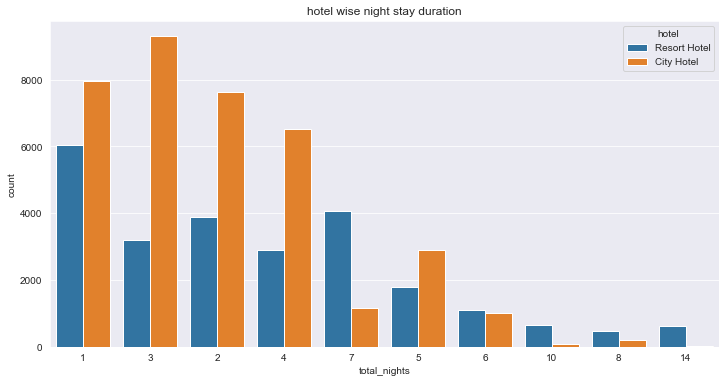

In [32]:
df_not_canceled.loc[:,'total_nights']=df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']

fig, ax=plt.subplots(figsize=(12,6))
ax.set_xlabel('no of nights')
ax.set_ylabel('no of nights')
ax.set_title('hotel wise night stay duration')
sns.countplot(x='total_nights',hue='hotel',data= df_not_canceled,
             order= df_not_canceled.total_nights.value_counts().iloc[:10].index,ax=ax);

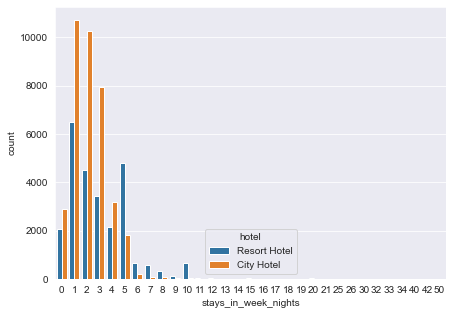

In [33]:
plt.subplots(figsize=(7,5))
sns.countplot(x='stays_in_week_nights',hue='hotel',data=df_not_canceled);

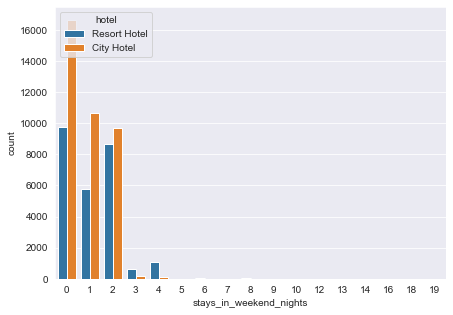

In [34]:
plt.subplots(figsize=(7,5))
sns.countplot(x='stays_in_weekend_nights',hue='hotel',data=df_not_canceled);

## Feature selection and feature engineering
#### lets try without splitting the hotels and try to apply decision tree or random forest 

In [35]:
## copy the dataframe
df_subset=df.copy()

In [36]:
# make a new column: which says 1 if the customer got the same room he reserved for by 
df_subset['Room']= 0
df_subset.loc[df_subset['reserved_room_type']==df_subset['assigned_room_type'],'Room']=1

In [37]:
# making a new column which contains 1 if the previous cancellations
# are more than the previous not cancelled 
df_subset['net_cancelled']=0
df_subset.loc[df_subset['previous_cancellations']>df_subset['previous_bookings_not_canceled'],'net_cancelled']=1

In [38]:
pd.set_option('display.max_columns', None)
df_subset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,1,0


In [39]:
df_subset=df_subset.drop(['arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month','previous_cancellations','previous_bookings_not_canceled','reserved_room_type','assigned_room_type','reservation_status','reservation_status_date'],axis=1)

In [40]:
pd.set_option('display.max_columns', None)
df_subset.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,Room,net_cancelled
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,Direct,Direct,0,3,No Deposit,0,0,0,Transient,0.0,0,0,1,0
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,Direct,Direct,0,4,No Deposit,0,0,0,Transient,0.0,0,0,1,0
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,No Deposit,0,0,0,Transient,75.0,0,0,0,0
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,No Deposit,304,0,0,Transient,75.0,0,0,1,0
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,No Deposit,240,0,0,Transient,98.0,0,1,1,0


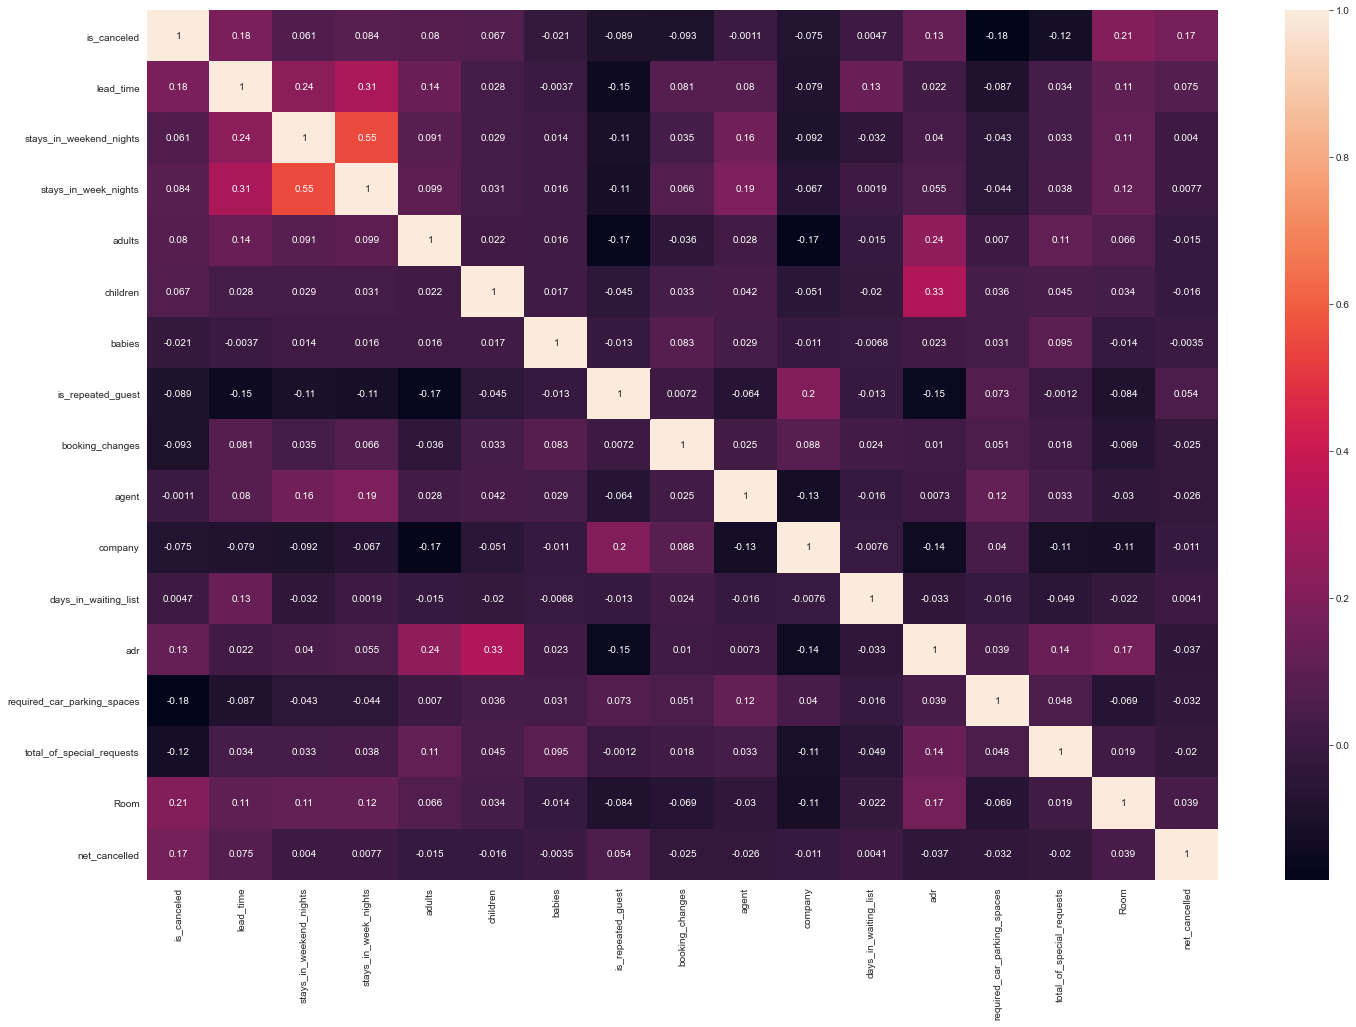

In [41]:
# plotting heatmap to see correleation with columns
fig, ax = plt.subplots(figsize=(24,16))
sns.heatmap(df_subset.corr(), annot=True, ax=ax);

### Applying Label encodig

In [42]:
df_subset.dtypes

hotel                           object
is_canceled                      int64
lead_time                        int64
stays_in_weekend_nights          int64
stays_in_week_nights             int64
adults                           int64
children                         int64
babies                           int64
meal                            object
country                         object
market_segment                  object
distribution_channel            object
is_repeated_guest                int64
booking_changes                  int64
deposit_type                    object
agent                            int64
company                          int64
days_in_waiting_list             int64
customer_type                   object
adr                            float64
required_car_parking_spaces      int64
total_of_special_requests        int64
Room                             int64
net_cancelled                    int64
dtype: object

In [43]:
cols=['hotel','meal','country','market_segment','distribution_channel','deposit_type','customer_type']
df_subset[cols]=df_subset[cols].apply(LabelEncoder().fit_transform)
df_subset.head(10)

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,Room,net_cancelled
0,1,0,342,0,0,2,0,0,0,136,3,1,0,3,0,0,0,0,2,0.0,0,0,1,0
1,1,0,737,0,0,2,0,0,0,136,3,1,0,4,0,0,0,0,2,0.0,0,0,1,0
2,1,0,7,0,1,1,0,0,0,60,3,1,0,0,0,0,0,0,2,75.0,0,0,0,0
3,1,0,13,0,1,1,0,0,0,60,2,0,0,0,0,304,0,0,2,75.0,0,0,1,0
4,1,0,14,0,2,2,0,0,0,60,6,3,0,0,0,240,0,0,2,98.0,0,1,1,0
6,1,0,0,0,2,2,0,0,0,136,3,1,0,0,0,0,0,0,2,107.0,0,0,1,0
7,1,0,9,0,2,2,0,0,1,136,3,1,0,0,0,303,0,0,2,103.0,0,1,1,0
8,1,1,85,0,3,2,0,0,0,136,6,3,0,0,0,240,0,0,2,82.0,0,1,1,0
9,1,1,75,0,3,2,0,0,2,136,5,3,0,0,0,15,0,0,2,105.5,0,0,1,0
10,1,1,23,0,4,2,0,0,0,136,6,3,0,0,0,240,0,0,2,123.0,0,0,1,0


### Train test split

In [44]:
X=df_subset.drop('is_canceled', axis=1)
y=df_subset['is_canceled']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [48]:
train_score= clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

In [49]:
print('Training accuracy of decision tree model is: ',train_score)


Training accuracy of decision tree model is:  0.9969123536425056


In [50]:
prediction = clf.predict(X_train.iloc[15].values.reshape(1,-1))

actual_value = y_train.iloc[15]

print(f'Predicted Value \t: {prediction[0]}')
print(f'Actual Value\t\t: {actual_value}')

Predicted Value 	: 0
Actual Value		: 0
